In [1]:
# default_exp data.eda

In [2]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
! pip install sentencepiece

     |████████████████████████████████| 1.2 MB 3.0 MB/s eta 0:00:01


# Exploratory Data Analysis 
>
>@danaderp 11.17.20 This is an exploratory data analysis for the codesearch net dataset. The goal of the exploration is to understand the code distribution of token information.
>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import time

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
import functools 
from operator import or_
from collections import Counter
import datetime

In [4]:
import sentencepiece as spm

In [5]:
import pickle
from pathlib import Path

In [6]:
from pandas.plotting import scatter_matrix
from pandas.plotting import bootstrap_plot
from sklearn import preprocessing

In [7]:
from collections import Counter

In [8]:
#export
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Fixing parameters

In [12]:
#nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024
#df_buggy.to_json(path / "buggy.jsonl", orient="records", lines=True)
dvc_path = Path('../dvc-icodegen/')
def params():
    return {
        'hyper': {
            'seq_length':100,
            'batch_size':64,
            'buffer_size':10000,
            'rnn_units':1024,
            'epochs':10
        },
        'bug_entropy':dvc_path / 'datax/data_z_covariates/Model-R 0.0.0 rnn_layers1_vocab10000_embed256_units1024/bug_fix_cross_entropy_z_v1.jsonl',
        'bug_taxonomy':dvc_path / 'datax/data_z_covariates/Model-R 0.0.0 rnn_layers1_vocab10000_embed256_units1024/bug_fix_error_taxonomy_z_v1.jsonl',
    }

In [13]:
params = params()

In [14]:
#tst
logging.info( params['bug_taxonomy'] )

2021-07-09 20:01:29,627 : INFO : ../dvc-icodegen/datax/data_z_covariates/Model-R 0.0.0 rnn_layers1_vocab10000_embed256_units1024/bug_fix_error_taxonomy_z_v1.jsonl


## EDA Next Token Analysis Analysis (by Taxonomy)
This dataset is for testing purpuses

In [36]:
#df_buggy.to_json(path / "buggy.jsonl", orient="records", lines=True)
df_error_tax = pd.read_json(
            params['bug_taxonomy'], orient="records", lines=True
        )

In [50]:
df_test = df_error_tax.y_exceptions.fillna( df_error_tax.y_exceptions.mode()[0] )

In [51]:
df_test

0         2.302470e-05
1         2.302470e-05
2         2.302470e-05
3         2.302470e-05
4         2.302470e-05
              ...     
129439    2.302470e-05
129440    2.302470e-05
129441    2.302470e-05
129442    9.771000e-07
129443    9.960000e-07
Name: y_exceptions, Length: 129444, dtype: float64

In [48]:
df_test = df_error_tax.interpolate(method='spline', order=1, limit=10, limit_direction='both')

In [49]:
df_test.head()

,y_blocks,y_exceptions,y_oop,y_tests,y_declarations,y_conditionals,y_loops,y_operators,y_datatypes,y_extra_tokens,...,z_numbersQty,z_assignmentsQty,z_mathOperationsQty,z_variablesQty,z_maxNestedBlocksQty,z_anonymousClassesQty,z_innerClassesQty,z_lambdasQty,z_uniqueWordsQty,z_modifiers
0,0.016686,0.000007,8.931800e-06,NaN,3.518000e-07,0.000018,0.000019,0.000316,0.000012,0.189851,...,1,3,0,2,0,0,0,0,8,1
1,0.016562,0.000007,8.914700e-06,NaN,3.518000e-07,0.000018,0.000019,0.000315,0.000012,0.190934,...,1,3,0,2,0,0,0,0,8,1
2,0.019514,0.000007,1.240000e-08,NaN,3.518000e-07,0.000010,0.000019,0.004353,0.000012,0.131582,...,0,0,1,0,1,0,0,0,17,1
3,0.020454,0.000007,1.240000e-08,NaN,3.518000e-07,0.000010,0.000019,0.004353,0.000012,0.129045,...,0,0,1,0,1,0,0,0,17,1
4,0.014277,0.000007,1.757276e-04,NaN,3.090000e-07,0.000018,0.000019,0.000488,0.000028,0.162347,...,2,4,2,0,0,0,0,0,17,1


In [47]:
df_error_tax.head()

,y_blocks,y_exceptions,y_oop,y_tests,y_declarations,y_conditionals,y_loops,y_operators,y_datatypes,y_extra_tokens,...,z_numbersQty,z_assignmentsQty,z_mathOperationsQty,z_variablesQty,z_maxNestedBlocksQty,z_anonymousClassesQty,z_innerClassesQty,z_lambdasQty,z_uniqueWordsQty,z_modifiers
0,0.016686,NaN,8.931800e-06,NaN,3.518000e-07,NaN,NaN,0.000316,NaN,0.189851,...,1,3,0,2,0,0,0,0,8,1
1,0.016562,NaN,8.914700e-06,NaN,3.518000e-07,NaN,NaN,0.000315,NaN,0.190934,...,1,3,0,2,0,0,0,0,8,1
2,0.019514,NaN,1.240000e-08,NaN,3.518000e-07,0.00001,NaN,0.004353,NaN,0.131582,...,0,0,1,0,1,0,0,0,17,1
3,0.020454,NaN,1.240000e-08,NaN,3.518000e-07,0.00001,NaN,0.004353,NaN,0.129045,...,0,0,1,0,1,0,0,0,17,1
4,0.014277,NaN,1.757276e-04,NaN,3.090000e-07,NaN,NaN,0.000488,0.000028,0.162347,...,2,4,2,0,0,0,0,0,17,1


In [17]:
potential_outcomes = ['y_blocks','y_exceptions','y_oop','y_tests','y_declarations','y_conditionals','y_loops','y_operators','y_datatypes','y_extra_tokens']

In [18]:
#Counting Nans
#A Nan in the next token predictions means that the token was not in the sample
df_error_tax.isnull().sum(axis = 0)

y_blocks                         0
y_exceptions                 97065
y_oop                         1387
y_tests                     128736
y_declarations               39952
y_conditionals               54658
y_loops                      97813
y_operators                   5575
y_datatypes                  74744
y_extra_tokens                   9
original_code                    0
transformed_code                 0
x_treatment                      0
z_count_subwords                 0
file                             0
class                            0
z_wmc                            0
z_totalMethodsQty                0
z_staticMethodsQty               0
z_publicMethodsQty               0
z_privateMethodsQty              0
z_protectedMethodsQty            0
z_defaultMethodsQty              0
z_abstractMethodsQty             0
z_finalMethodsQty                0
z_synchronizedMethodsQty         0
z_totalFieldsQty                 0
z_staticFieldsQty                0
z_publicFieldsQty   

In [20]:
df_error_tax.describe().round(4)

,y_blocks,y_exceptions,y_oop,y_tests,y_declarations,y_conditionals,y_loops,y_operators,y_datatypes,y_extra_tokens,...,z_numbersQty,z_assignmentsQty,z_mathOperationsQty,z_variablesQty,z_maxNestedBlocksQty,z_anonymousClassesQty,z_innerClassesQty,z_lambdasQty,z_uniqueWordsQty,z_modifiers
count,129444.0000,32379.0000,128057.0000,708.0,89492.000,74786.0000,31631.0000,123869.0000,54700.0000,129435.0000,...,129444.0000,129444.0000,129444.0000,129444.0000,129444.0000,129444.0000,129444.0000,129444.0000,129444.0000,129444.0
mean,0.0274,0.0000,0.0016,0.0,0.000,0.0000,0.0000,0.0029,0.0000,0.1390,...,0.9137,1.8846,0.5713,1.2322,1.0186,0.0231,0.0003,0.0061,11.3367,1.0
std,0.0180,0.0000,0.0037,0.0,0.000,0.0000,0.0001,0.0121,0.0000,0.0411,...,1.7201,1.5809,1.3633,1.1612,0.8304,0.1572,0.0202,0.0924,4.9949,0.0
min,0.0005,0.0000,0.0000,0.0,0.000,0.0000,0.0000,0.0000,0.0000,0.0002,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,1.0
25%,0.0136,0.0000,0.0000,0.0,0.000,0.0000,0.0000,0.0001,0.0000,0.1110,...,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8.0000,1.0
50%,0.0241,0.0000,0.0000,0.0,0.000,0.0000,0.0000,0.0004,0.0000,0.1372,...,0.0000,2.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,10.0000,1.0
75%,0.0374,0.0000,0.0014,0.0,0.000,0.0000,0.0000,0.0011,0.0000,0.1650,...,1.0000,3.0000,0.0000,2.0000,1.0000,0.0000,0.0000,0.0000,13.0000,1.0
max,0.1810,0.0002,0.1678,0.0,0.001,0.0005,0.0080,0.4925,0.0019,0.3694,...,41.0000,19.0000,21.0000,11.0000,6.0000,4.0000,2.0000,5.0000,336.0000,1.0


In [34]:
df_error_tax[df_error_tax.y_tests >= 0.5]

,y_blocks,y_exceptions,y_oop,y_tests,y_declarations,y_conditionals,y_loops,y_operators,y_datatypes,y_extra_tokens,...,z_numbersQty,z_assignmentsQty,z_mathOperationsQty,z_variablesQty,z_maxNestedBlocksQty,z_anonymousClassesQty,z_innerClassesQty,z_lambdasQty,z_uniqueWordsQty,z_modifiers


In [21]:
#Normalization
min_max_scaler = preprocessing.MinMaxScaler()
df_error_tax_scaled = pd.DataFrame(min_max_scaler.fit_transform(df_error_tax[potential_outcomes]), columns = potential_outcomes)

In [22]:
df_error_tax_scaled['x_treatment'] = df_error_tax['x_treatment']

In [24]:
df_error_tax_scaled[potential_outcomes].describe().round(4)

,y_blocks,y_exceptions,y_oop,y_tests,y_declarations,y_conditionals,y_loops,y_operators,y_datatypes,y_extra_tokens
count,129444.0000,32379.0000,128057.0000,708.0000,89492.0000,74786.0000,31631.0000,123869.0000,54700.0000,129435.0000
mean,0.1491,0.0268,0.0093,0.2029,0.0008,0.0342,0.0025,0.0060,0.0073,0.3759
std,0.1000,0.0465,0.0218,0.1406,0.0096,0.0318,0.0099,0.0245,0.0182,0.1113
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0728,0.0033,0.0000,0.1183,0.0002,0.0148,0.0005,0.0003,0.0004,0.3002
50%,0.1310,0.0067,0.0001,0.1672,0.0003,0.0234,0.0011,0.0007,0.0018,0.3712
75%,0.2042,0.0326,0.0084,0.2412,0.0004,0.0427,0.0021,0.0022,0.0065,0.4464
max,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [31]:
df_error_tax_scaled[df_error_tax_scaled.y_exceptions >= 0.5]

,y_blocks,y_exceptions,y_oop,y_tests,y_declarations,y_conditionals,y_loops,y_operators,y_datatypes,y_extra_tokens,x_treatment
874,0.048990,0.514426,1.097617e-03,NaN,0.000301,0.031269,NaN,0.002141,NaN,0.356408,False
875,0.050810,0.514426,1.097350e-03,NaN,0.000301,0.030206,NaN,0.002470,NaN,0.376102,True
10468,0.094306,0.557312,5.506779e-05,NaN,0.000343,NaN,NaN,0.000218,0.001447,0.645922,False
10469,0.094973,0.557312,5.144110e-05,NaN,0.000343,NaN,NaN,0.000201,0.001447,0.581423,True
12900,0.038031,0.528511,5.057415e-02,NaN,NaN,0.017211,NaN,0.003317,NaN,0.333814,False
12901,0.037825,0.528511,5.057415e-02,NaN,NaN,0.017211,NaN,0.003292,NaN,0.333935,True
24684,0.123524,0.526670,4.897563e-07,NaN,NaN,NaN,NaN,0.001173,0.002779,0.410146,False
24685,0.012924,0.526670,4.897563e-07,NaN,NaN,NaN,NaN,0.001173,0.002779,0.410687,True
64780,0.292221,0.518025,5.057415e-02,NaN,0.000337,NaN,NaN,0.000441,NaN,0.351660,False
64781,0.280712,0.518025,5.057415e-02,NaN,0.000337,NaN,NaN,0.000441,NaN,0.348624,True


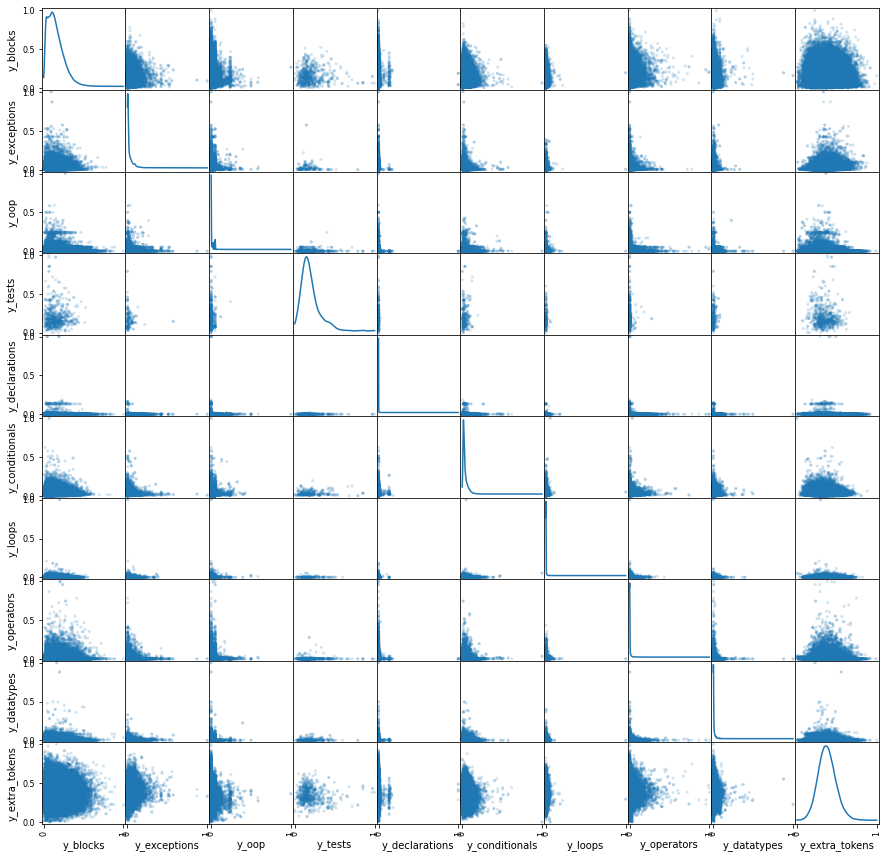

In [25]:
scatter_matrix(
    df_error_tax_scaled[potential_outcomes], 
    alpha=0.2, 
    figsize=(15, 15), 
    diagonal="kde"
);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6066685dc0>,
      dtype=object)

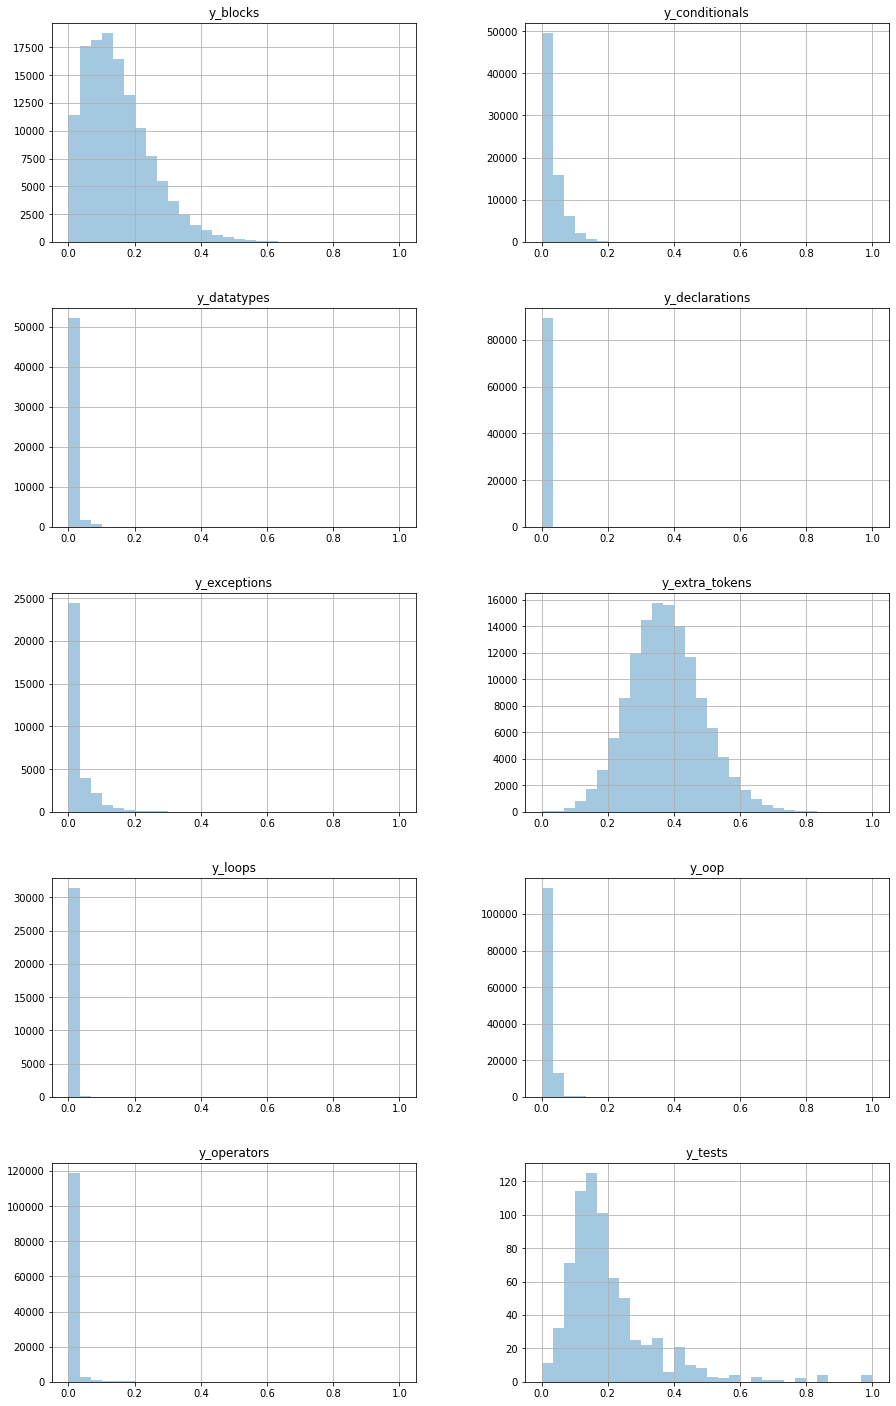

In [26]:
df_error_tax_scaled[potential_outcomes].hist(
    bins=30, 
    alpha=0.4, 
    layout=(5, 2), 
    figsize = (15,25)
)

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


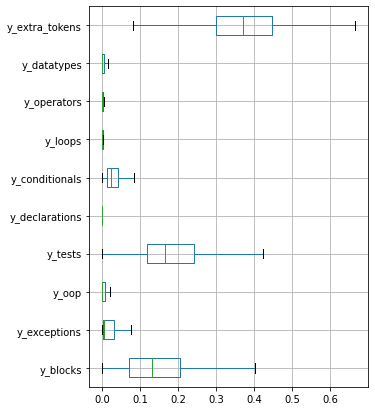

In [27]:
df_error_tax_scaled.boxplot(
    column=potential_outcomes,
    showfliers=False,
    vert=False,
    figsize=(5,7)
)

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


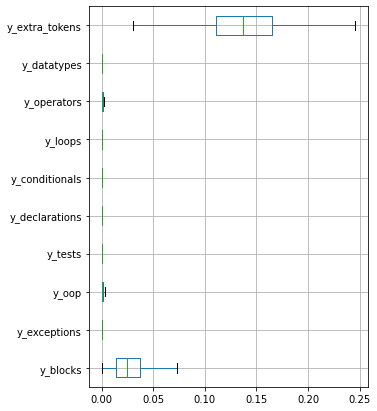

In [30]:
df_error_tax.boxplot(
    column=potential_outcomes,
    showfliers=False,
    vert=False,
    figsize=(5,7)
)

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f60544c4760>,
      dtype=object)

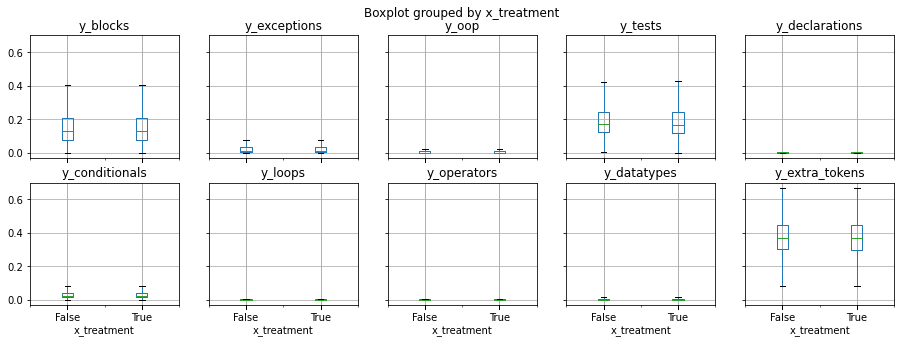

In [29]:
#Can we observe any significant difference between the error in bug and not buggy?
df_error_tax_scaled.boxplot(
    column=potential_outcomes, 
    showfliers=False, 
    #vert=False,
    layout=(2, 5), 
    figsize = (15,5),
    by="x_treatment"
)

## EDA Cross-Entropy Analysis
This dataset is for testing purpuses

In [ ]:
df_cross_entr = pd.read_json(
            params['tb_02'], orient="records", lines=True
        )

ValueError: Expected object or value

In [ ]:
df_cross_entr.head()

,code,y_cross_entropy,x_treatment
0,<private> <void> success<(>io.netty.channel.Ch...,6.006220,False
1,<private> <void> success<(>io.netty.channel.Ch...,6.008038,True
2,<private> <void> handleConnectRequest<(>com.as...,6.368741,False
3,<private> <void> handleConnectRequest<(>com.as...,6.337473,True
4,<@>java.lang.Override<n><protected> <void> onS...,3.927699,False


In [ ]:
df_cross_entr.describe()

,y_cross_entropy
count,129444.000000
mean,6.142502
std,1.510858
min,2.066005
25%,5.038853
50%,5.982966
75%,7.085069
max,12.283474


<AxesSubplot:>

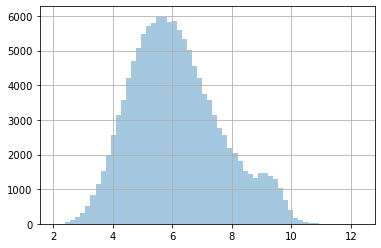

In [ ]:
df_cross_entr['y_cross_entropy'].hist(
    bins=60, 
    alpha=0.4
)

<AxesSubplot:>

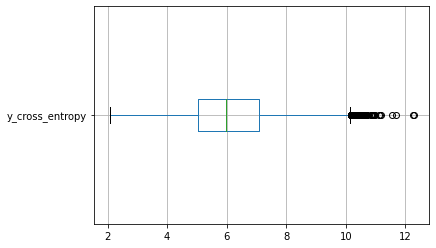

In [ ]:
df_cross_entr.boxplot(
    column='y_cross_entropy',
    showfliers=True,
    vert=False,
    #figsize=(5,7)
)

<AxesSubplot:title={'center':'y_cross_entropy'}, xlabel='x_treatment'>

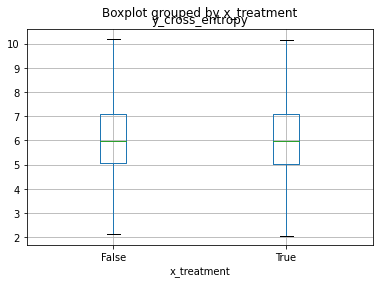

In [ ]:
df_cross_entr.boxplot(
    column='y_cross_entropy',
    showfliers=False,
    by="x_treatment"
    #figsize=(5,7)
)

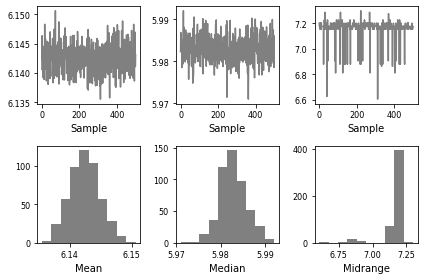

In [ ]:
bootstrap_plot(
    df_cross_entr['y_cross_entropy'], 
    size=100000, 
    samples=500, 
    color="grey");

In [ ]:
#Avg Number of Subwords 
count_subwords = [len( eval(mtd) ) for mtd in df_train['code_tokens'].values]

In [ ]:
df_train['count_tokens'] = count_subwords

In [ ]:
#BPE 

# Descriptive Statistics

All Java Set

In [ ]:
java_df.describe()

,code_len,bpe32_len
count,467203.000000,467203.000000
mean,113.079653,146.274557
std,189.121245,303.804009
min,20.000000,20.000000
25%,42.000000,50.000000
50%,67.000000,81.000000
75%,122.000000,150.000000
max,27192.000000,52975.000000


All Java Partition

In [ ]:
df_train.describe()

,code_len,bpe32_len
count,384868.000000,384868.000000
mean,113.720826,147.151002
std,194.007951,313.904001
min,20.000000,20.000000
25%,42.000000,50.000000
50%,67.000000,81.000000
75%,122.000000,151.000000
max,27192.000000,52975.000000


In [ ]:
logging.info([ p.describe() for p in list_all_partitions])

2020-11-17 12:31:54,629 : INFO : [            code_len      bpe32_len
count  384868.000000  384868.000000
mean      113.720826     147.151002
std       194.007951     313.904001
min        20.000000      20.000000
25%        42.000000      50.000000
50%        67.000000      81.000000
75%       122.000000     151.000000
max     27192.000000   52975.000000,            code_len     bpe32_len
count  14605.000000  14605.000000
mean      94.331736    120.097843
std      115.802231    171.079255
min       21.000000     21.000000
25%       39.000000     46.000000
50%       59.000000     71.000000
75%      104.000000    127.000000
max     3099.000000   5747.000000,            code_len     bpe32_len
count  25011.000000  25011.000000
mean     114.274599    148.204710
std      166.432695    245.938732
min       21.000000     22.000000
25%       43.000000     52.000000
50%       69.000000     84.000000
75%      125.000000    155.000000
max     5685.000000  10015.000000,            code_len     bpe

In [ ]:
logging.info([ stats.median_absolute_deviation(p['code_len'].values) for p in list_all_partitions])

2020-11-17 12:29:30,408 : INFO : [45.9606, 37.065, 47.4432, 44.477999999999994]


Train Partition

In [ ]:
# Frequent Characters
train_tokens = df_train.code_tokens.values

In [ ]:
train_vocab_tokens = [ eval(method)  for method in train_tokens ] #Evaluating given tokens

In [ ]:
train_counter_tokens = [ Counter(method) for method in train_vocab_tokens ] #Counting the words

In [ ]:
train_counter = functools.reduce(lambda a,b : a+b, train_counter_tokens ) ## [Warning! Time Consuming]

In [ ]:
train_counter

NameError: name 'train_counter' is not defined

In [ ]:
#Persisting the counter object
with open(params['eda']+'['+ str(datetime.datetime.now()) +']-codesearchnet_token_counts.pickle', 'wb') as outputfile:
    pickle.dump( train_counter, outputfile )